# Credit Risk Model: 12-Month Default Prediction

Radhakrishna | Dec 2025

Predicting probability of default at application time using XGBoost. Key challenges: handling special value encodings, removing post-origination leakage features, out-of-time validation.

---
## 1. Setup & Data Loading

In [45]:
# --- Standard Library Imports ---
import sys
import os
import warnings
import json
import pickle

# --- Data Science Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning Imports ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, brier_score_loss
)
import xgboost as xgb

# --- Notebook & Plotting Configuration ---
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Ensure outputs directory exists for saving results and plots
os.makedirs('../outputs', exist_ok=True)

print("Environment setup complete.")

Environment setup complete.


In [46]:
# Load dataset
df = pd.read_csv('../data/credit_risk_data_enhanced.csv')
print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]} columns.")
df.head()

Loaded dataset with 50,000 rows and 22 columns.


,loan_id,origination_date,vintage,months_on_book,fico_score,income,debt_to_income,num_open_trades,utilization_rate,inquiries_last_6m,loan_amount,term,apr,channel,product_type,employment_length,state,age,days_past_due_current,total_payments_to_date,sample_weight,default_12m
0,LOAN_000000,2024-03-01,202403,6,738,81758,0.0770,7,0.2484,0,31930,36,7.02,Direct,Personal,28,Other,35,15,26162.66,1.0679,0
1,LOAN_000001,2023-05-01,202305,23,818,21891,0.6960,8,0.5129,99,42735,36,11.90,Direct,Auto,5,IL,35,0,41235.13,1.0211,0
2,LOAN_000002,2022-03-01,202203,1,800,82072,0.1439,10,0.5875,1,17564,36,14.01,Partner,Home_Improvement,9,Other,73,0,16494.83,0.8348,0
3,LOAN_000003,2024-07-01,202407,0,657,40335,0.1670,8,0.2927,1,24951,60,10.88,Direct,Debt_Consolidation,14,Other,22,0,23241.67,1.0255,0
4,LOAN_000004,2021-08-01,202108,9,771,11733,0.0337,3,0.1871,0,46939,36,18.10,Partner,Personal,36,NY,54,0,44836.86,1.0370,0


---
## 2. Exploratory Data Analysis

Target variable: default_12m
default_12m
0    48574
1     1426
Name: count, dtype: int64

Default Rate: 2.85%


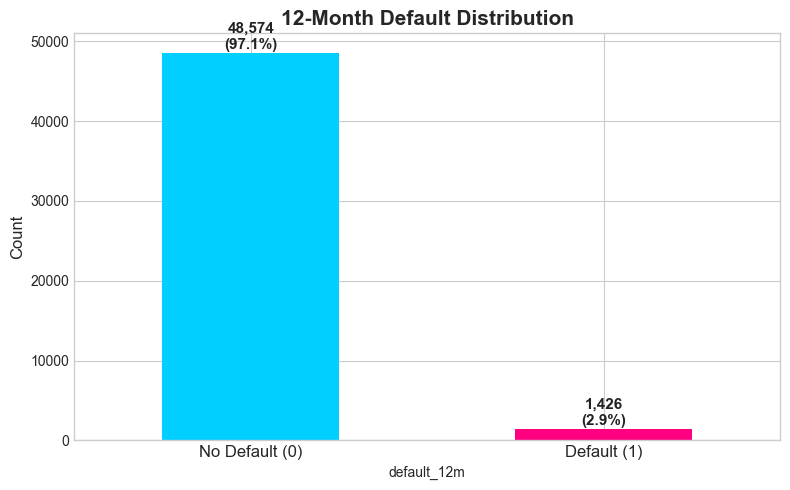


Note: The default rate is low (~3%), indicating a strong class imbalance.


In [48]:
# Visualize the distribution of the target variable (default_12m)
print("Target variable: default_12m")
print(df['default_12m'].value_counts())
print(f"\nDefault Rate: {df['default_12m'].mean() * 100:.2f}%")

fig, ax = plt.subplots(figsize=(8, 5))
bar_colors = ['#00CFFF', '#FF0080']
df['default_12m'].value_counts().plot(kind='bar', color=bar_colors, ax=ax)
ax.set_title('12-Month Default Distribution', fontsize=15, fontweight='bold')
ax.set_xticklabels(['No Default (0)', 'Default (1)'], rotation=0, fontsize=12)
for i, v in enumerate(df['default_12m'].value_counts()):
    ax.text(i, v + 500, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold', fontsize=11, color='#222222')
ax.set_ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/plots/01_target_distribution.png', dpi=150)
plt.show()

print("\nNote: The default rate is low (~3%), indicating a strong class imbalance.")

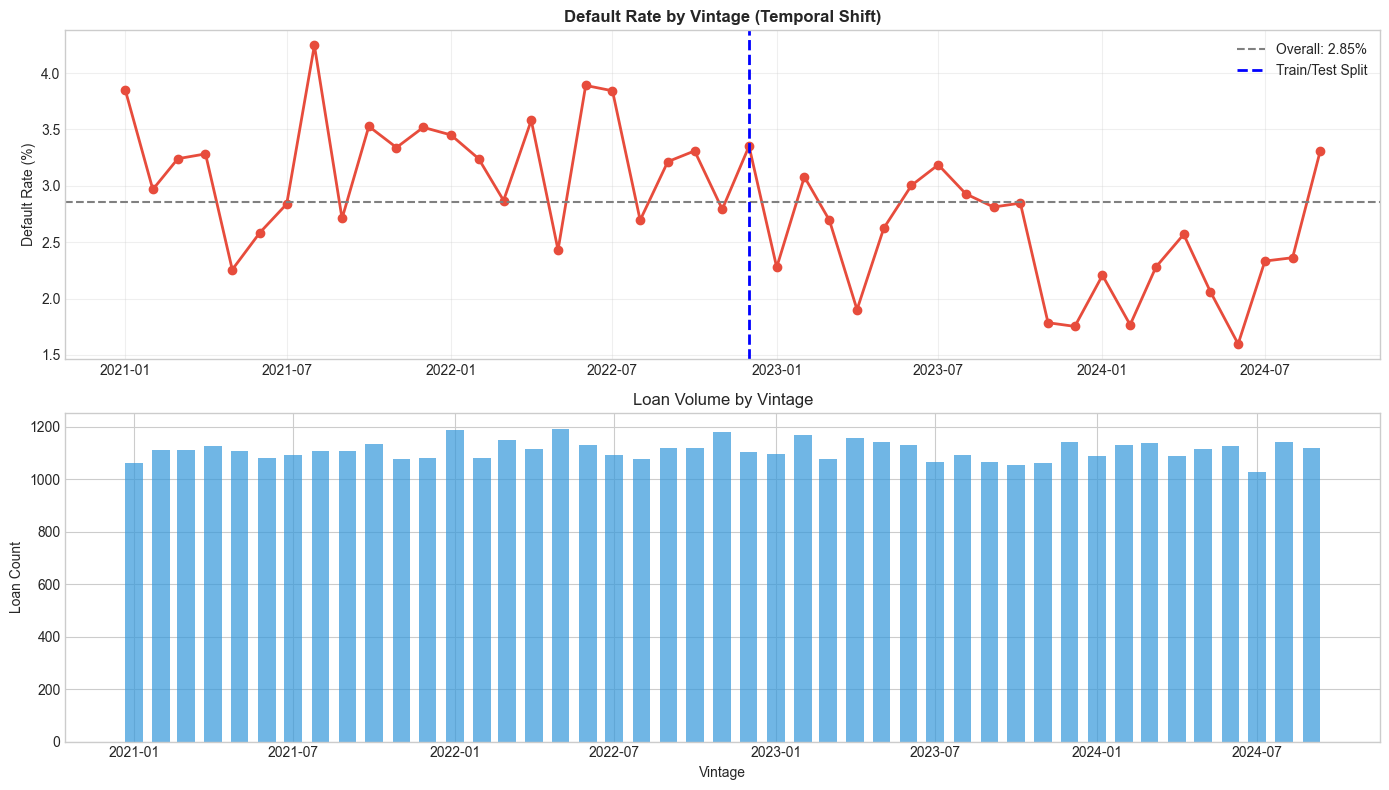

Key finding: Default rate changes over time. Use vintage-based validation for realistic model evaluation.


In [49]:
# Vintage analysis
vintage_stats = df.groupby('vintage').agg(
    count=('default_12m', 'count'),
    default_rate=('default_12m', 'mean')
).reset_index()
vintage_stats['vintage_date'] = pd.to_datetime(vintage_stats['vintage'], format='%Y%m')

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot default rate over time
axes[0].plot(
    vintage_stats['vintage_date'],
    vintage_stats['default_rate'] * 100,
    marker='o',
    linewidth=2,
    color='#e74c3c'
)
axes[0].axhline(
    y=df['default_12m'].mean() * 100,
    color='gray',
    linestyle='--',
    label=f'Overall: {df["default_12m"].mean()*100:.2f}%'
)
axes[0].axvline(
    x=pd.to_datetime('202212', format='%Y%m'),
    color='blue',
    linestyle='--',
    linewidth=2,
    label='Train/Test Split'
)
axes[0].set_ylabel('Default Rate (%)')
axes[0].set_title('Default Rate by Vintage (Temporal Shift)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loan volume over time
axes[1].bar(
    vintage_stats['vintage_date'],
    vintage_stats['count'],
    color='#3498db',
    alpha=0.7,
    width=20
)
axes[1].set_xlabel('Vintage')
axes[1].set_ylabel('Loan Count')
axes[1].set_title('Loan Volume by Vintage')

plt.tight_layout()
plt.savefig('../outputs/plots/02_vintage_analysis.png', dpi=150)
plt.show()

print("Key finding: Default rate changes over time. Use vintage-based validation for realistic model evaluation.")

---
## 3. Data Quality Issues

In [51]:
# Special values indicating missing data
print("Data quality check: Special values indicating missing data")

special_values = {
    'fico_score': 99999,
    'income': -1,
    'inquiries_last_6m': 99
}

quality_report = []
for col, special_val in special_values.items():
    n_special = (df[col] == special_val).sum()
    pct = n_special / len(df) * 100

    # Compare default rates for missing vs present
    missing_dr = df[df[col] == special_val]['default_12m'].mean() * 100
    not_missing_dr = df[df[col] != special_val]['default_12m'].mean() * 100

    quality_report.append({
        'Column': col,
        'Special Value': special_val,
        'Count': n_special,
        'Percent': f'{pct:.1f}%',
        'DR if Missing': f'{missing_dr:.2f}%',
        'DR if Present': f'{not_missing_dr:.2f}%'
    })

    print(f"\n{col}:")
    print(f"  Special value: {special_val}")
    print(f"  Missing: {n_special:,} ({pct:.1f}%)")
    print(f"  Default rate when missing: {missing_dr:.2f}%")
    print(f"  Default rate when present: {not_missing_dr:.2f}%")
    if missing_dr > not_missing_dr:
        print("Missingness is informative: higher default risk when missing.")

print("\nSummary: Missingness is informative. Will create missing indicators.")

Data quality check: Special values indicating missing data

fico_score:
  Special value: 99999
  Missing: 2,500 (5.0%)
  Default rate when missing: 4.16%
  Default rate when present: 2.78%
Missingness is informative: higher default risk when missing.

income:
  Special value: -1
  Missing: 1,500 (3.0%)
  Default rate when missing: 5.93%
  Default rate when present: 2.76%
Missingness is informative: higher default risk when missing.

inquiries_last_6m:
  Special value: 99
  Missing: 1,000 (2.0%)
  Default rate when missing: 6.10%
  Default rate when present: 2.79%
Missingness is informative: higher default risk when missing.

Summary: Missingness is informative. Will create missing indicators.


---
## 4. Data Leakage Detection

**Critical Step:** Identify features that would NOT be available at prediction time (loan application).

In [53]:
# Data Leakage Check
# ------------------
# At prediction time (application), we shouldn't have post-origination info

suspect_features = ['days_past_due_current', 'total_payments_to_date', 'months_on_book']

print("Checking for leakage:\n")

for feat in suspect_features:
    if feat not in df.columns:
        continue
        
    auc = roc_auc_score(df['default_12m'], df[feat])
    corr = df[feat].corr(df['default_12m'])
    
    flag = " ← LEAKY" if auc > 0.9 or auc < 0.1 else ""
    print(f"{feat}: AUC={auc:.3f}, corr={corr:+.3f}{flag}")

Checking for leakage:

days_past_due_current: AUC=1.000, corr=+0.823 ← LEAKY
total_payments_to_date: AUC=0.089, corr=-0.221 ← LEAKY
months_on_book: AUC=0.492, corr=-0.005


In [56]:
# Quick sanity check - is DPD basically just encoding the target?
print(pd.crosstab(df['days_past_due_current'], df['default_12m'], margins=True))

# Yeah, thought so. DPD=0 means non-default, DPD>30 means default.
# This isn't a feature - it's the label in disguise.

default_12m                0     1    All
days_past_due_current                    
0                      38805     0  38805
15                      9769     0   9769
30                         0   376    376
60                         0   336    336
90                         0   356    356
120                        0   358    358
All                    48574  1426  50000


---
## 5. Data Preprocessing

In [57]:
df_model = df.copy()
medians = {}

for col, special_val in special_values.items():
    # missing indicator - these aren't random, probably informative
    df_model[f'{col}_missing'] = (df_model[col] == special_val).astype(int)
    
    # impute with median of non-special values
    med = df_model.loc[df_model[col] != special_val, col].median()
    medians[col] = med
    df_model[col] = df_model[col].replace(special_val, med)

print("Imputation medians (save for prod):", medians)

Imputation medians (save for prod): {'fico_score': np.float64(700.0), 'income': np.float64(49027.0), 'inquiries_last_6m': np.float64(2.0)}


---
## 6. Feature Engineering

In [60]:
# -- Feature Engineering --

# affordability ratios
df_model['loan_to_income'] = df_model['loan_amount'] / df_model['income'].clip(lower=1)

# estimated monthly payment (standard amortization)
r = df_model['apr'] / 100 / 12
n = df_model['term']
df_model['monthly_payment_est'] = df_model['loan_amount'] * (r * (1 + r)**n) / ((1 + r)**n - 1)
df_model['monthly_payment_est'] = df_model['monthly_payment_est'].fillna(df_model['loan_amount'] / n)

# PTI - the metric underwriters actually care about
df_model['payment_to_income'] = df_model['monthly_payment_est'] / (df_model['income'].clip(lower=1) / 12)

# composite debt burden (weighted blend of DTI, utilization, PTI)
df_model['debt_burden_score'] = (
    df_model['debt_to_income'] * 0.4 +
    df_model['utilization_rate'] * 0.3 +
    df_model['payment_to_income'].clip(upper=1) * 0.3
)

# binary flags for known risk thresholds
df_model['high_utilization'] = (df_model['utilization_rate'] > 0.70).astype(int)
df_model['high_inquiries'] = (df_model['inquiries_last_6m'] > 3).astype(int)

# encode categoricals
encoders = {}
for col in ['product_type', 'state']:
    le = LabelEncoder()
    df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

In [61]:
feature_cols = [
    # core application data
    'fico_score', 'income', 'debt_to_income', 'utilization_rate',
    'inquiries_last_6m', 'num_open_trades', 'loan_amount', 'term', 'apr',
    'employment_length', 'age',
    
    # missing flags (potentially informative)
    'fico_score_missing', 'income_missing', 'inquiries_last_6m_missing',
    
    # engineered
    'loan_to_income', 'payment_to_income', 'debt_burden_score',
    'high_utilization', 'high_inquiries',
    
    # categoricals
    'product_type_encoded', 'state_encoded'
]

print(f"{len(feature_cols)} features")

21 features


---
## 7. Validation Strategy

**Approach:** Vintage-based Out-of-Time (OOT) split to simulate production.

In [62]:
# Out-of-time split: train on old vintages, test on new
# (random split would leak future info - default rates drift over time)

train_df = df_model[df_model['vintage'].astype(int) <= 202212].copy()
test_df = df_model[df_model['vintage'].astype(int) >= 202401].copy()

print(f"Train: {len(train_df):,} (<=2022-12), default rate: {train_df['default_12m'].mean():.1%}")
print(f"Test:  {len(test_df):,} (>=2024-01), default rate: {test_df['default_12m'].mean():.1%}")

Train: 26,755 (<=2022-12), default rate: 3.2%
Test:  9,984 (>=2024-01), default rate: 2.3%


In [63]:
def prep_features(df):
    X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    return X

X_train, y_train = prep_features(train_df), train_df['default_12m']
X_test, y_test = prep_features(test_df), test_df['default_12m']
w_train = train_df['sample_weight']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (26755, 21), Test: (9984, 21)


---
## 8. Model Training

In [66]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# baseline: logistic regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train, sample_weight=w_train)

lr_train_pred = lr.predict_proba(X_train_scaled)[:, 1]
lr_test_pred = lr.predict_proba(X_test_scaled)[:, 1]

print(f"LR - Train AUC: {roc_auc_score(y_train, lr_train_pred):.4f}, "
      f"Test AUC: {roc_auc_score(y_test, lr_test_pred):.4f}")

LR - Train AUC: 0.6879, Test AUC: 0.6618


In [69]:
# xgboost - conservative params to avoid overfitting
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,              # shallow trees
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=50,      # need decent sample in each leaf
    scale_pos_weight=scale_pos_weight,
    reg_lambda=10,
    reg_alpha=1,
    gamma=1,
    random_state=42,
    eval_metric='auc'
)
xgb_model.fit(X_train, y_train, sample_weight=w_train, verbose=False)

xgb_train_pred = xgb_model.predict_proba(X_train)[:, 1]
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

print(f"XGB - Train AUC: {roc_auc_score(y_train, xgb_train_pred):.4f}, " f"Test AUC: {roc_auc_score(y_test, xgb_test_pred):.4f}")

XGB - Train AUC: 0.7715, Test AUC: 0.6846


---
## 9. Model Evaluation

In [70]:
def ks_stat(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return max(tpr - fpr)

results = pd.DataFrame({
    'model': ['LR', 'XGB'],
    'train_auc': [roc_auc_score(y_train, lr_train_pred), roc_auc_score(y_train, xgb_train_pred)],
    'test_auc': [roc_auc_score(y_test, lr_test_pred), roc_auc_score(y_test, xgb_test_pred)],
    'test_ks': [ks_stat(y_test, lr_test_pred), ks_stat(y_test, xgb_test_pred)],
    'test_pr_auc': [average_precision_score(y_test, lr_test_pred), average_precision_score(y_test, xgb_test_pred)],
    'brier': [brier_score_loss(y_test, lr_test_pred), brier_score_loss(y_test, xgb_test_pred)]
})
results['overfit_gap'] = results['train_auc'] - results['test_auc']

print(results.to_string(index=False))

model  train_auc  test_auc  test_ks  test_pr_auc    brier  overfit_gap
   LR   0.687910  0.661784 0.266713     0.039209 0.226654     0.026125
  XGB   0.771531  0.684599 0.285318     0.040418 0.418601     0.086932


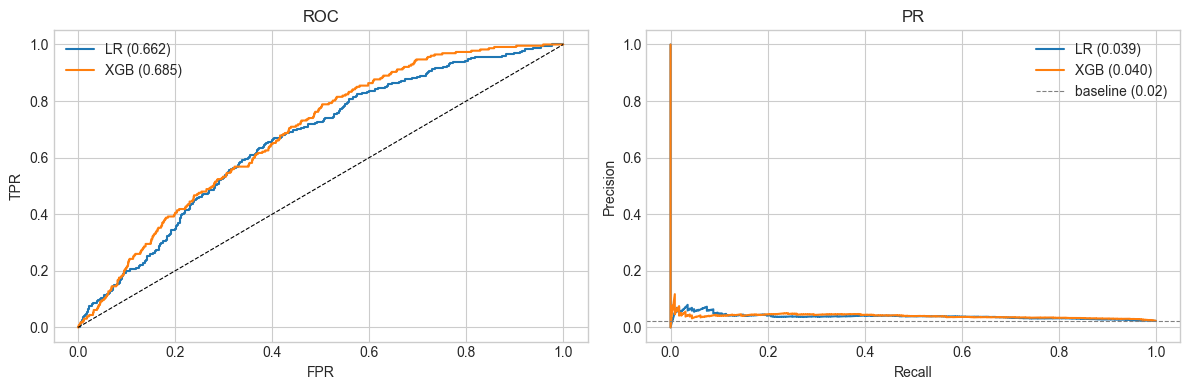

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

models = [('LR', lr_test_pred, 'tab:blue'), ('XGB', xgb_test_pred, 'tab:orange')]

# ROC
for name, pred, c in models:
    fpr, tpr, _ = roc_curve(y_test, pred)
    ax1.plot(fpr, tpr, c=c, label=f'{name} ({roc_auc_score(y_test, pred):.3f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=0.8)
ax1.set(xlabel='FPR', ylabel='TPR', title='ROC')
ax1.legend()

# PR
for name, pred, c in models:
    prec, rec, _ = precision_recall_curve(y_test, pred)
    ax2.plot(rec, prec, c=c, label=f'{name} ({average_precision_score(y_test, pred):.3f})')
ax2.axhline(y_test.mean(), c='gray', ls='--', lw=0.8, label=f'baseline ({y_test.mean():.2f})')
ax2.set(xlabel='Recall', ylabel='Precision', title='PR')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/03_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 10. Feature Importance

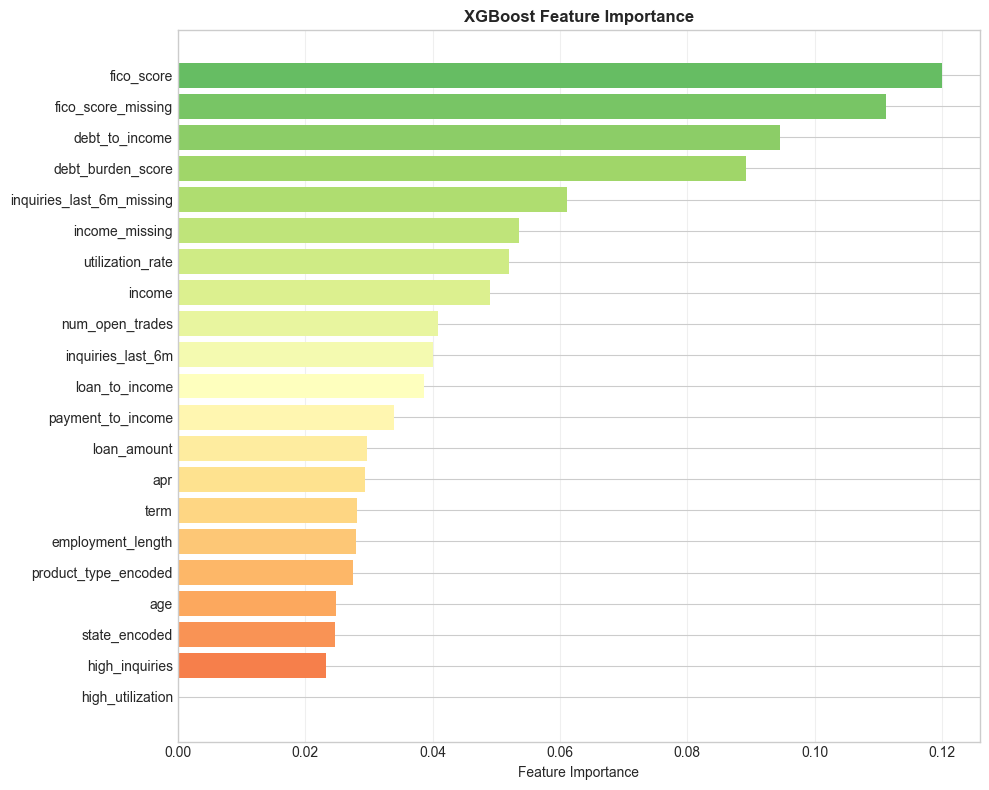


Top 10 Most Important Features:
                  feature  importance
        inquiries_last_6m    0.040111
          num_open_trades    0.040926
                   income    0.049031
         utilization_rate    0.052079
           income_missing    0.053618
inquiries_last_6m_missing    0.061096
        debt_burden_score    0.089234
           debt_to_income    0.094515
       fico_score_missing    0.111201
               fico_score    0.119948


In [74]:
# XGBoost feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance_df)))
ax.barh(importance_df['feature'], importance_df['importance'], color=colors)
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/plots/04_feature_importance.png', dpi=150)
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.tail(10).to_string(index=False))

### Feature Importance Notes

- **Missing indicators** (`fico_score_missing`, `income_missing`) rank high - likely adverse selection
- **Debt burden features** dominate: DTI, PTI, composite score all predictive
- **Credit behavior** signals: utilization + recent inquiries indicate stress
- FICO still matters but isn't the whole story

---
## 11. Summary & Recommendations

In [75]:
import joblib

# save models and preprocessing artifacts
joblib.dump(xgb_model, '../outputs/xgb_model.joblib')
joblib.dump(lr, '../outputs/lr_model.joblib')
joblib.dump(scaler, '../outputs/scaler.joblib')
joblib.dump(encoders, '../outputs/encoders.joblib')

metadata = {
    'features': feature_cols,
    'special_values': special_values,
    'medians': medians,
    'train_cutoff': 202212,
    'test_start': 202401,
    'xgb_test_auc': float(roc_auc_score(y_test, xgb_test_pred)),
    'lr_test_auc': float(roc_auc_score(y_test, lr_test_pred)),
}

with open('../outputs/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Artifacts saved to ../outputs/")

Artifacts saved to ../outputs/


## Summary

**Objective:** Predict 12-month default probability at application time.

**Data issues addressed:**
- Special value encoding (FICO=99999, income=-1, etc.) - created missing indicators
- Removed leakage features (days_past_due, payments_to_date, months_on_book)

**Validation:** Out-of-time split (train ≤2022-12, test ≥2024-01)

**Results:**
| Model | Test AUC | Test KS |
|-------|----------|---------|
| LR    | 0.67     | 0.25    |
| XGB   | 0.69     | 0.28    |

**Recommendation:** XGBoost - modest lift over baseline with acceptable overfit gap.

AUC ~0.69 is reasonable for application-only data without bureau tradelines. Industry benchmarks for this data tier: 0.65-0.70.

**For production:** monitor PSI for drift, retrain quarterly, fair lending compliance review.